# Predicting price of a laptop

# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Exploratory analysis](#explore)
    1. [Continous variables](#continous)
    2. [Categorical variables](#categorical)
4. [Missing values](#missing)
    1. [Identifying Nones in dataset](#identify)
5. [Comparing distribution of features of training and test set](#compare)
6. [Encoding of categorical variables](#encoding)
    1. [One-hot encoding](#onehot)
    2. [Target encoding within preprocessing pipeline](#target)
7. [Correlations between features](#corr)
8. [Train-test split](#traintest)
9. [RMSE](#rmse)
10. [Modelling](#modelling)
    1. [Linear regression](#lr)
    2. [XGBoost](#xgboost)
    3. [Explaining prediction of XGBoost](#expxgboost)
    4. [Catboost](#catboost)
11. [Summary](#summary)


## 1. Introduction <a name='introduction' ></a>

In this task we are going to predict price of a laptop given pieces of information concerning its components and sales information (like state of the laptop or warranty type). The data were given in zip file, in a json format. Our task involves predicting price on the test set, with RMSE as an evaluation metric.

## 2. Import <a name='import'></a>

We import necessary packages along with self-written and github-based scripts.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle
import os
from functools import reduce

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import warnings

import xgboost as xgb
from catboost import CatBoostRegressor
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
import shap

from utils import list_to_one_hot, get_top_abs_correlations, missing_values, check_singular_columns, type_preprocessing
from psi import calculate_psi, calculate_psi_report
from visuals import plot_learning_curve, multipleplots, plot_missing_values
from featureunion import PandasFeatureUnion

from regressor import RegressorOptimizer
from paralytics.preprocessing.transformation import CategoricalGrouper, ColumnProjector, TypeSelector, ColumnSelector
from paralytics.encoding import TargetEncoder
from paralytics.collinearity_reduction import VIFSelector

In [3]:
#setting seed variable for random states
seed=42
#setting default figure size
plt.rcParams['figure.figsize']=(10,10)

Importing data from unpacked zip file.

In [4]:
dataset = pd.read_json("dane_do_wyslania/public-dataset.json")
dataset_test = pd.read_json("dane_do_wyslania/hidden-Xs.json")
with open('names_polish.json', 'r') as file:
    names = json.load(file)
dataset.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora', 'stan',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy '],
      dtype='object')

One can see that the target variable has English names with underscores whereas the rest of them are in Polish with spaces. Since working on underscored variable names is easier and cleaner we are going to replace them with custom dictionary, translating to Polish and shortening the names at the same time to standarize features' names language across whole notebook. The description of variables can be found in README.md file which is attached to repository.

In [5]:
dataset.rename(columns=names, inplace=True)
dataset_test.rename(columns=names, inplace=True)
dataset.reset_index(inplace=True)
dataset_test.reset_index(inplace=True)

In [6]:
dataset.columns

Index(['index', 'cena_kup_teraz', 'gpu_typ', 'komunikacja', 'rozdzielczosc',
       'cpu_rdzenie', 'ram_wielkosc', 'os', 'hdd_typ', 'sterowanie',
       'multimedia', 'ram_typ', 'cpu_ghz', 'cpu_seria', 'stan', 'hdd_rozmiar',
       'gwarancja', 'matryca_wielkosc'],
      dtype='object')

## 3. Exploratory analysis <a name='explore'></a>

We will have a look at the dataset.

In [7]:
dataset.head(5)

,index,cena_kup_teraz,gpu_typ,komunikacja,rozdzielczosc,cpu_rdzenie,ram_wielkosc,os,hdd_typ,sterowanie,multimedia,ram_typ,cpu_ghz,cpu_seria,stan,hdd_rozmiar,gwarancja,matryca_wielkosc
0,0,5524.0,grafika dedykowana,[bluetooth],1920 x 1080,4,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr4,2.6,intel core i7,nowy,480.0,producenta,"15"" - 15.9"""
1,10,1720.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,4,4 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.2,amd a8,nowy,1000.0,producenta,"17"" - 17.9"""
2,100,2649.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,2,12 gb,[windows 10 home],ssd + hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.3,intel core i3,nowy,1240.0,producenta,"15"" - 15.9"""
3,1000,1199.0,grafika zintegrowana,[bluetooth],1366 x 768,2,2 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr3,1.6,intel celeron,nowy,128.0,producenta,"11.9"" i mniej"
4,10000,4049.0,grafika dedykowana,"[lan 10/100/1000 mbps, nfc (near field communi...",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr4,2.7,intel core i5,nowy,256.0,producenta,"15"" - 15.9"""


In [8]:
dataset_test.head(5)

,index,gpu_typ,komunikacja,rozdzielczosc,cpu_rdzenie,ram_wielkosc,os,hdd_typ,sterowanie,multimedia,ram_typ,cpu_ghz,cpu_seria,stan,hdd_rozmiar,gwarancja,matryca_wielkosc
0,1,grafika zintegrowana,None,1366 x 768,2,4 gb,[windows 8.1 professional 64-bit],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",None,2.4,intel core i3,nowy,500.0,producenta,"15"" - 15.9"""
1,10002,grafika zintegrowana,[bluetooth],1920 x 1080,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[kamera, głośniki, mikrofon]",ddr4,2.5,intel core i5,nowy,256.0,producenta,"13"" - 13.9"""
2,10003,None,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 7 professional 64-bit],None,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,120.0,producenta,"15"" - 15.9"""
3,10004,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,2,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,480.0,producenta,"17"" - 17.9"""
4,10005,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,8 gb,[windows 10 professional],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,1000.0,producenta,"15"" - 15.9"""


In [9]:
dataset.describe()

,index,cena_kup_teraz,cpu_ghz,hdd_rozmiar
count,7853.000000,7853.000000,6917.00000,7372.000000
mean,5841.533427,3475.527050,2.33743,653.239826
std,3372.147684,1730.904165,0.39109,477.616013
min,0.000000,429.000000,0.00000,0.000000
25%,2942.000000,2199.000000,2.00000,256.000000
50%,5830.000000,3149.000000,2.50000,500.000000
75%,8766.000000,4399.000000,2.60000,1000.000000
max,11719.000000,15472.650000,3.90000,10000.000000


From this look one can see that there are either 0's or missing values in case of:
* cpu_ghz
* hdd_rozmiar

The target values is within range of 430 to 15K zloty, which does not raise any alarms associated with potential outliers. Moreover, we can observe that majority of variables in our dataset are not numeric type.

In [10]:
print(dataset.shape, dataset_test.shape, dataset.dtypes, sep = '\n')

(7853, 18)
(3869, 17)
index                 int64
cena_kup_teraz      float64
gpu_typ              object
komunikacja          object
rozdzielczosc        object
cpu_rdzenie          object
ram_wielkosc         object
os                   object
hdd_typ              object
sterowanie           object
multimedia           object
ram_typ              object
cpu_ghz             float64
cpu_seria            object
stan                 object
hdd_rozmiar         float64
gwarancja            object
matryca_wielkosc     object
dtype: object


So, we have less than 8K records with 17 features. What we can already observe from preliminiary look at the data is the fact that most of them are categorical variables, however not all of the categories differ in the same way. 
For example "rozdzielczosc" and "ram_wielkosc" features have some order associated with them. Those are called ordinal features. On the other hand we have "hdd_typ" or "sterowanie" which are categorical features. There are also variables which can be considered purely categorical, such as "cpu_seria", however it may be possible to tell which series of the processors have better performance in general (like superior performance of i7 series as compared to i5 series). One can think of possible arguments in AMD vs Intel competition that could be revealed during this task :) Moreover we will refer to both ordinal and categorical features as categorical throughout whole notebook.

## 3.1 Continous variables <a name='continous'></a>

Firstly we will take a look at the variables that are marked as float type in our dataset along with target variable.

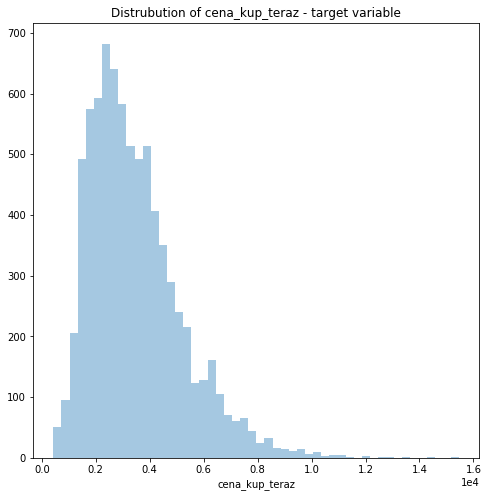

Skewness: 1.1918197625049383
Kurtosis: 2.2971867391894416


In [11]:
def plot_target_distribution(data, target_name):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.distplot(data[target_name], kde=False)
    ax.set_title("Distrubution of cena_kup_teraz - target variable")
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-3,3))
    plt.show()
    skew = data[target_name].skew()
    kurt = data[target_name].kurt()
    print(f'Skewness: {skew}\nKurtosis: {kurt}')
    
plot_target_distribution(
                        dataset, 
                        "cena_kup_teraz"
)

We can observe that our target variable:

* deviates from the normal distribution.
* shows peakedness.

We are going to divide features found in dataset based on their type:

In [12]:
numeric_features = [column for column,dtype in zip(dataset.columns, dataset.dtypes) if dtype == 'float64']

Let's take a look into contunous variables dependencies

At first we are going to use boxplot to tell whether there are some outliers in our dataset.

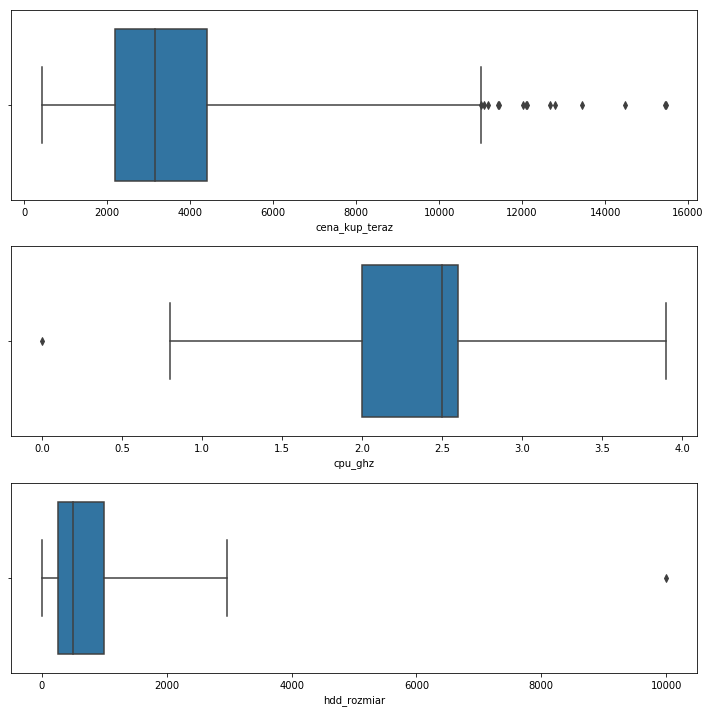

In [13]:
multipleplots(
              x = numeric_features, 
              data=dataset, 
              ncols=1, 
              nrows=3, 
              figsize=(10, 10), 
              plot_type='boxplot',
              whis=3
)
plt.tight_layout()

Some points from the dataset were identified as outliers, however the one with huge hdd_rozmiar seems to be the most apparent one. We are going to investigate this examples further:

In [14]:
dataset.loc[dataset.loc[:, 'hdd_rozmiar'] > 5e3, :]

,index,cena_kup_teraz,gpu_typ,komunikacja,rozdzielczosc,cpu_rdzenie,ram_wielkosc,os,hdd_typ,sterowanie,multimedia,ram_typ,cpu_ghz,cpu_seria,stan,hdd_rozmiar,gwarancja,matryca_wielkosc
7644,9717,4597.0,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.6,intel core i7,nowy,10000.0,producenta,"15"" - 15.9"""


I couldn't find a laptop with internal hard drive capacity higher than 2TB, however there were laptops with such values in description as the one presented below:

https://allegro.pl/oferta/solidny-laptop-dell-inspiron-5758-17-cali-7901272449

but when looking into attached link from other hardware store:

https://www.x-kom.pl/p/250711-notebook-laptop-173-dell-inspiron-5758-i7-5500-8gb-1000-fhd-gf920m.html

one can see that it's actually 1TB hard drive, so I'm going to assume that this case is similar to the one presented here and assign 1TB value.

In [15]:
dataset.loc[dataset.loc[:, 'hdd_rozmiar'] > 5e3, 'hdd_rozmiar'] = 1e3

There is also the case with cpu_ghz value equal to 0:

In [16]:
dataset.loc[dataset.loc[:, 'cpu_ghz'] == 0, :]

,index,cena_kup_teraz,gpu_typ,komunikacja,rozdzielczosc,cpu_rdzenie,ram_wielkosc,os,hdd_typ,sterowanie,multimedia,ram_typ,cpu_ghz,cpu_seria,stan,hdd_rozmiar,gwarancja,matryca_wielkosc
1305,125,2825.0,grafika zintegrowana,"[lan 10/100/1000 mbps, nfc (near field communi...",1920 x 1080,2,8 gb,[windows 8.1 home 64-bit],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,0.0,intel core i7,nowy,256.0,producenta,"14"" - 14.9"""


We are going to treat this example as missing value in our further analysis

In [17]:
dataset.loc[dataset.loc[:, 'cpu_ghz'] == 0, 'cpu_ghz'] = None

Furthermore we would like to investigate relationship between cpu_ghz and hdd_rozmiar in a more detailed way, since we suspect that they can be significant indicators of the price and it was not so visible in the case of pairplot:

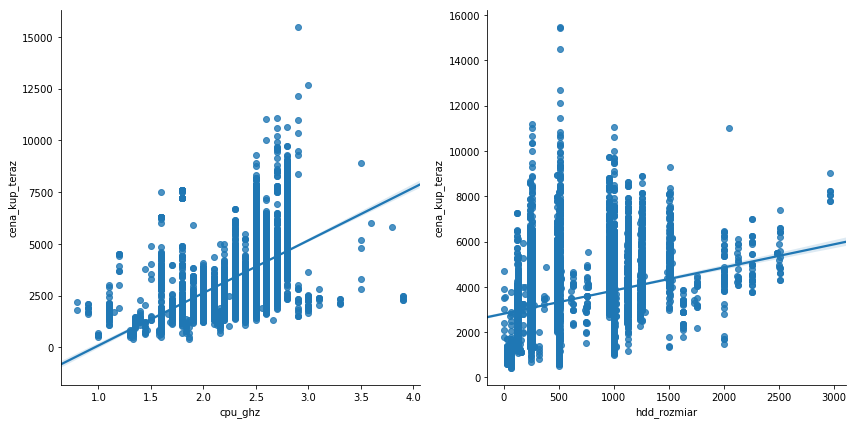

In [18]:
multipleplots(
              data=dataset,
              x=['cpu_ghz', 'hdd_rozmiar'],
              y='cena_kup_teraz',
              nrows=1,
              ncols=2,
              figsize=(12, 6), 
              plot_type='regplot'
)
sns.despine()
plt.tight_layout()

What we can observe from the above graphs is as follows:
* There are clear groups in case of hard drive capacity (we can clearly distinguish 256GB, 512GB etc.)
* cpu_ghz seems to have more importance than hdd_rozmiar, although the approximation to the negative prices seen on the graph may by misleading

## 3.2 Categorical features <a name='categorical'></a>

In [19]:
cat_features = [column for column,dtype in zip(dataset.columns, dataset.dtypes) if dtype == 'object']
list_features = ['multimedia', 'komunikacja', 'os', 'sterowanie']

We are going to need 14 graphs to show all categorical variables from our dataset, although there are some that contain list type variables, which cannot be used in default seaborn barplot, so I decided to leave them out. Furthermore, for the purposes of readability, I decided to plot resulution and cpu_seria on seperate graph.

In [20]:
cat_features_unlist = [feature for feature in cat_features if feature not in list_features+['cpu_seria', 'rozdzielczosc']]

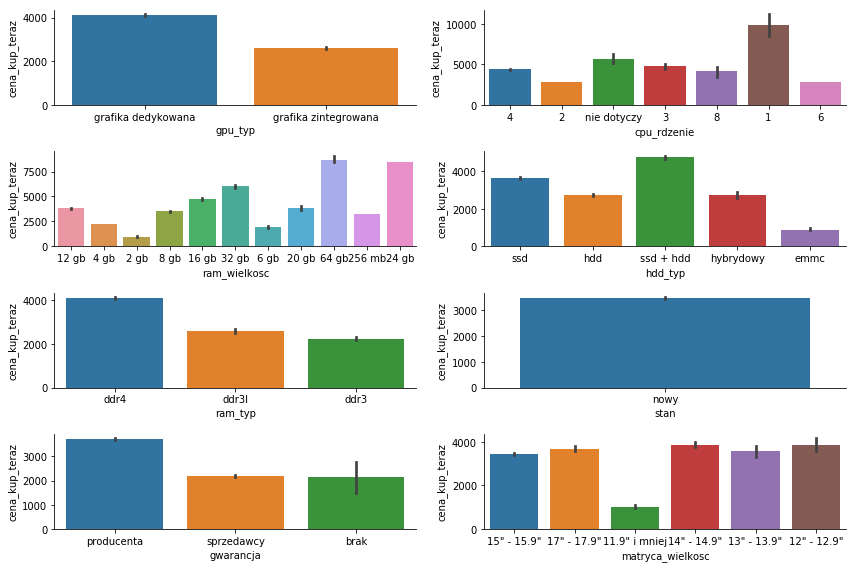

In [21]:
multipleplots(
              data=dataset,
              x=cat_features_unlist,
              y='cena_kup_teraz',
              nrows=4,
              ncols=2,
              figsize=(12, 8), 
              plot_type='barplot'
)
sns.despine()
plt.tight_layout()

There several things to notice from this plot:

* Warranty from producer is preferable to the seller's one.
* There are only new laptops in this dataset, so actually we can just drop this variable.
* Only if the screen is really small the price really varies.
* There is a category in cpu_rdzenie visible which states "nie dotyczy". We are going to investigate this class further.
* The more ram, the bigger the price
* GPU dedicated to the laptop makes its price higher on average, which follows the notion the such GPU's are usually faster than integrated ones.

Plotting remaining two categories:

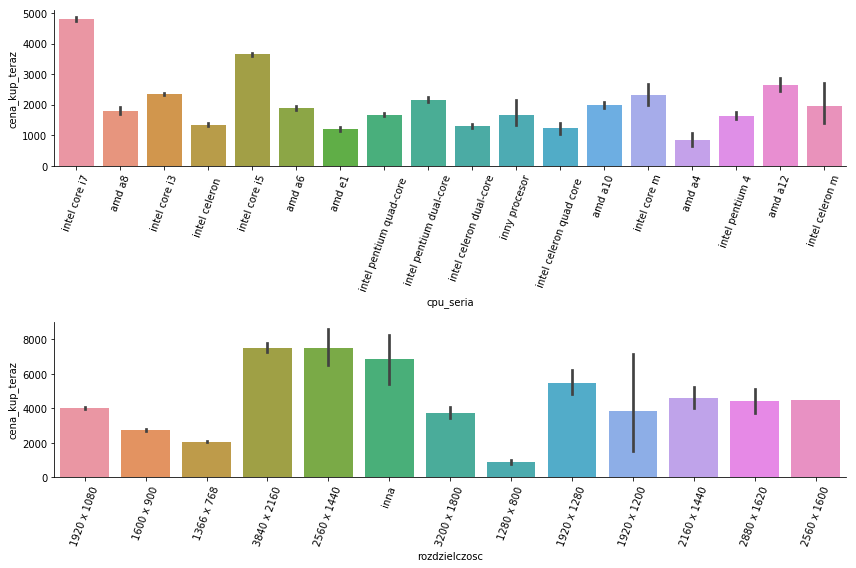

In [22]:
multipleplots(
              data=dataset,
              x=['cpu_seria', 'rozdzielczosc'],
              y='cena_kup_teraz',
              nrows=2,
              ncols=1,
              figsize=(12, 8), 
              plot_type='barplot',
              rotation=70
)
sns.despine()
plt.tight_layout()

As in aforementioned statemenent concerning Intel vs AMD competition, one can see that i7 and i5 CPUs correspond to more expensive laptops, both having higher average price than the most prestigous from AMD CPUs - a12 model.

As mentioned before, we will drop the "state" variable, since it doesn't give us any additional information. Moreover we are going to start using prefix "pre" for preprocessed data.

In [23]:
dataset_pre = dataset[dataset.columns.difference(['stan'])].copy()
dataset_test = dataset[dataset_test.columns.difference(['stan'])].copy()


## 4. Missing values <a name='missing'></a>

## 4.1 Identifying Nones in dataset <a name='identify'></a>

As mentioned in our analysis of categorical features, we are going to investigate case of "nie dotyczy" category in cpu_rdzenie variable.

In [24]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_rdzenie"] == "nie dotyczy", :].head(10)

,cena_kup_teraz,cpu_ghz,cpu_rdzenie,cpu_seria,gpu_typ,gwarancja,hdd_rozmiar,hdd_typ,index,komunikacja,matryca_wielkosc,multimedia,os,ram_typ,ram_wielkosc,rozdzielczosc,sterowanie
51,6450.0,NaN,nie dotyczy,None,None,producenta,NaN,None,10077,None,None,None,None,None,None,None,None
85,4899.0,1.8,nie dotyczy,None,grafika zintegrowana,producenta,NaN,None,10127,"[bluetooth, nfc (near field communication)]",None,None,[windows 10 home],None,8 gb,None,None
223,2868.9,NaN,nie dotyczy,None,None,producenta,NaN,None,10320,None,None,None,None,None,None,None,None
452,2497.9,NaN,nie dotyczy,None,None,producenta,NaN,None,1064,None,None,None,None,None,None,None,None
534,6750.0,NaN,nie dotyczy,None,None,producenta,NaN,None,10744,None,None,None,None,None,None,None,None
541,6160.0,NaN,nie dotyczy,None,None,producenta,NaN,None,10751,None,None,None,None,None,None,None,None
636,6158.9,NaN,nie dotyczy,None,None,producenta,NaN,None,10869,None,None,None,None,None,None,None,None
647,2868.9,NaN,nie dotyczy,None,None,producenta,NaN,None,10883,None,None,None,None,None,None,None,None
665,2910.0,NaN,nie dotyczy,None,None,producenta,NaN,None,10911,None,None,None,None,None,None,None,None
712,10180.0,NaN,nie dotyczy,None,None,producenta,NaN,None,10972,None,None,None,None,None,None,None,None


We can see that majority of these examples correponds to the cases when most of the features are missing. We are going to see how many such cases actually exist in the dataset.

In [25]:
missing = dataset_pre.loc[dataset_pre.isnull().sum(axis=1)/dataset_pre.shape[1] > 0.75, :]
missing.isnull().sum()

cena_kup_teraz        0
cpu_ghz             255
cpu_rdzenie           0
cpu_seria           255
gpu_typ             255
gwarancja             0
hdd_rozmiar         255
hdd_typ             255
index                 0
komunikacja         255
matryca_wielkosc    255
multimedia          255
os                  255
ram_typ             255
ram_wielkosc        255
rozdzielczosc       255
sterowanie          255
dtype: int64

There are 255 examples with missing values higher than 75%. Moreover we can see that besides state of the laptop and warranty type there is not much in this part of dataset. We are going to remove these examples from the dataset.

In [26]:
#TODO - consider not removing missing values
dataset_pre = dataset_pre.loc[~dataset_pre['index'].isin(missing['index']), :]

Remaining examples are presented below:

In [27]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_rdzenie"] == "nie dotyczy", :]

,cena_kup_teraz,cpu_ghz,cpu_rdzenie,cpu_seria,gpu_typ,gwarancja,hdd_rozmiar,hdd_typ,index,komunikacja,matryca_wielkosc,multimedia,os,ram_typ,ram_wielkosc,rozdzielczosc,sterowanie
85,4899.0,1.8,nie dotyczy,None,grafika zintegrowana,producenta,NaN,None,10127,"[bluetooth, nfc (near field communication)]",None,None,[windows 10 home],None,8 gb,None,None
1191,6299.0,1.6,nie dotyczy,None,grafika zintegrowana,producenta,NaN,None,11645,"[bluetooth, nfc (near field communication)]",None,None,[windows 10 home],None,8 gb,None,None
4013,3349.0,NaN,nie dotyczy,intel core i5,grafika dedykowana,brak,NaN,hdd,4878,None,"15"" - 15.9""",None,[windows 10 professional],None,8 gb,None,"[klawiatura, touchpad, klawiatura podświetlana..."
4965,1399.0,NaN,nie dotyczy,intel celeron,grafika dedykowana,producenta,NaN,hdd,6136,None,None,None,None,ddr3,4 gb,1366 x 768,None


Since there are only 4 such examples (and moreover cpu_ghz and cpu_seria values indicate so), we are going to fill them with mode of this category, which is equal to 2.

In [28]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_rdzenie"] == "nie dotyczy", 'cpu_rdzenie'] = \
dataset_pre.loc[:, 'cpu_rdzenie'].mode()[0]

dataset_test.loc[dataset_test.loc[:, "cpu_rdzenie"] == "nie dotyczy", 'cpu_rdzenie'] = \
dataset_test.loc[:, 'cpu_rdzenie'].mode()[0]

With dataset prepared in the way presented above we are going to check whether there are some missing values in the rest of it. And the plot all of these variables that contain some missing part.

             Total   Percent
cpu_ghz        682  0.089760
ram_typ        609  0.080153
komunikacja    527  0.069360
multimedia     453  0.059621
sterowanie     423  0.055673
os             395  0.051987


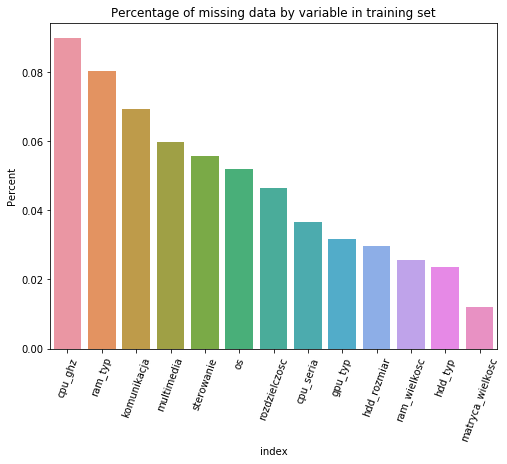

In [29]:
plot_missing_values(missing_values(dataset_pre),"Percentage of missing data by variable in training set")

             Total   Percent
cpu_ghz        937  0.119317
ram_typ        864  0.110022
komunikacja    782  0.099580
multimedia     708  0.090157
sterowanie     678  0.086336
os             650  0.082771


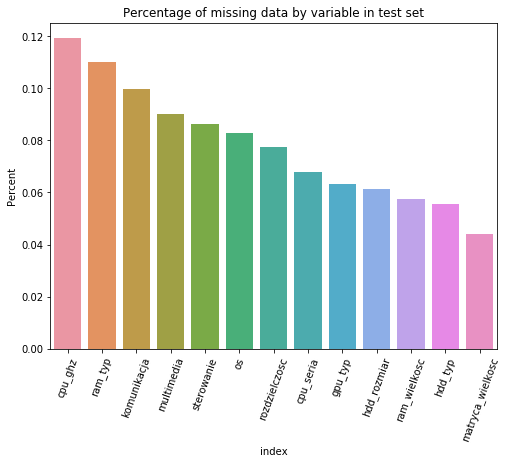

In [30]:
plot_missing_values(missing_values(dataset_test),"Percentage of missing data by variable in test set")

So one can see that the distribution of missing values is similar both in training and test set. Moreover, there are no missing values of target variable in our training set. From the above graphs the most concerning missing values are those associated with CPU and RAM.

Checking value counts for each cpu_seria:

In [31]:
dataset_pre['cpu_seria'].value_counts()

intel core i5               2595
intel core i7               2324
intel core i3               1399
amd a6                       195
intel pentium dual-core      175
intel celeron dual-core      170
intel celeron                120
intel pentium quad-core       87
inny procesor                 70
amd a8                        42
amd a10                       29
intel celeron quad core       27
amd e1                        22
amd a12                       21
intel pentium 4               15
intel core m                  12
amd a4                        11
intel celeron m                6
Name: cpu_seria, dtype: int64

Since already the dominating classes are i5 and i7 processors and the number of missing values in this case in not very high, we are going to fill them with most frequent one (i5 series).

In [32]:
def fill_with_most_frequent(data, column):
    return data.loc[:, column].fillna(data.loc[:, column].value_counts().index[0])

In [33]:
dataset_pre.loc[:, 'cpu_seria'] = fill_with_most_frequent(dataset_pre, 'cpu_seria')
dataset_test.loc[:, 'cpu_seria'] = fill_with_most_frequent(dataset_test, 'cpu_seria')

After that we plan to impute missing values of cpu clock with mean value of each cpu_seria, since its quite common that, for example, i3 series has lower operating frequency than CPUs from i7 series.

In [34]:
print(dataset_pre.groupby(['cpu_seria'])['cpu_ghz'].agg('mean'),
      dataset_test.groupby(['cpu_seria'])['cpu_ghz'].agg('mean'), sep="\n")

cpu_seria
amd a10                     2.222222
amd a12                     2.690476
amd a4                      1.263636
amd a6                      1.962827
amd a8                      1.987805
amd e1                      1.364286
inny procesor               1.679655
intel celeron               1.553043
intel celeron dual-core     1.795032
intel celeron m             1.370000
intel celeron quad core     1.462800
intel core i3               2.114509
intel core i5               2.378361
intel core i7               2.635796
intel core m                0.977778
intel pentium 4                  NaN
intel pentium dual-core     2.045562
intel pentium quad-core     1.510704
Name: cpu_ghz, dtype: float64
cpu_seria
amd a10                     2.222222
amd a12                     2.690476
amd a4                      1.263636
amd a6                      1.962827
amd a8                      1.987805
amd e1                      1.364286
inny procesor               1.679655
intel celeron            

Our preliminiary notions are clearly represented in the data, visible both for AMD and Intel processors. The only problem remains with Pentium 4 series, which does not have assigned frequency in any case represented. Maybe not everyone remembers that, but Pentium 4 processors possesed very high operational frequency values (up to 4 ghz), so we are going to impute them with max value of the resulting dataset. From our previous analysis we can see that it's going to be 3.9 ghz.

In [35]:
def fill_mean_by_group(data, group, column):
    return data.groupby([group])[column].transform(lambda x: x.fillna(x.mean()))

In [36]:
dataset_pre.loc[:, 'cpu_ghz'] = fill_mean_by_group(dataset_pre, 'cpu_seria', 'cpu_ghz')
#Filling for remaining Pentium 4 series
dataset_pre.loc[:, 'cpu_ghz'] = dataset_pre.loc[:, 'cpu_ghz'].fillna(dataset_pre['cpu_ghz'].max())

dataset_test.loc[:, 'cpu_ghz'] = fill_mean_by_group(dataset_test, 'cpu_seria', 'cpu_ghz')
#Filling for remaining Pentium 4 series
dataset_test.loc[:, 'cpu_ghz'] = dataset_test.loc[:, 'cpu_ghz'].fillna(dataset_test['cpu_ghz'].max())

Similar approach, although not as well justified, will be applied to hard drives, RAM and screen size.

In [37]:
dataset_pre.loc[:, 'hdd_typ'] = fill_with_most_frequent(dataset_pre, 'hdd_typ')
dataset_pre.loc[:, 'hdd_rozmiar'] = fill_mean_by_group(dataset_pre, 'hdd_typ', 'hdd_rozmiar')

dataset_test.loc[:, 'hdd_typ'] = dataset_test['hdd_typ'].fillna(dataset_test['hdd_typ'].value_counts().index[0])
dataset_test.loc[:, 'hdd_rozmiar'] = fill_mean_by_group(dataset_test, 'hdd_typ', 'hdd_rozmiar')

We are moving to filling categorical variables now - instead of average value per group, our imputer is going to be the most frequent value per group

In [56]:
for imputer, var_to_fill in zip(['matryca_wielkosc', 'ram_typ'], ['rozdzielczosc', 'ram_wielkosc']):
    dataset_pre.loc[:, imputer] = dataset_pre[imputer].fillna(dataset_pre[imputer].value_counts().index[0])
    dataset_pre.loc[:, var_to_fill] = dataset_pre.groupby([imputer])[var_to_fill].transform(lambda x: x.fillna(x.mode()[0])) 
    dataset_test.loc[:, imputer] = dataset_test[imputer].fillna(dataset_test[imputer].value_counts().index[0])
    dataset_test.loc[:, var_to_fill] = dataset_test.groupby([imputer])[var_to_fill].transform(lambda x: x.fillna(x.mode()[0]))

We are going to leave GPU as None type, since there is hardly any variable that we can directly associate with. The rest of missing variables are from features with list type values and they are going to be one-hot encoded later in the notebook

## 5. Comparing distribution of features of training and test set<a name='compare'></a>

When one wants to predict a value of certain variable, we should make sure that distrubtion from all datasets that are used are coming from the same distribution. We are going to use Population Stability Index in order to verify whether these two samples come from similar distribution. It is usually considered that PSI value lower 0.1 indicates that given variable is stable between two datasets.

In [119]:
x = dataset_pre.loc[:, 'cpu_seria'].value_counts()/len(dataset_pre.loc[:, 'cpu_seria'])
calculate_psi_report(dataset_pre, dataset_test, columns_num = ['hdd_rozmiar', 'cpu_ghz'])

TypeError: calculate_psi_report() got an unexpected keyword argument 'columns_num'

In [100]:
psi_value = 0
corr = 0.0001

def sub_psi(e_perc, a_perc, corr):
    '''Calculate the actual PSI value from comparing the values.
       Update the actual value to a very small number if equal to zero
    '''
    if a_perc == 0:
        a_perc = corr
    if e_perc == 0:
        e_perc = corr

    value = (e_perc - a_perc) * np.log(e_perc / a_perc)
    return value

def psi_dataframe(
                data_expected: pd.DataFrame,
                data_actual: pd.DataFrame,
                column: str
): 
    expected = data_expected.loc[:, column].value_counts()/len(data_expected.loc[:, column])
    actual = data_actual.loc[:, column].value_counts()/len(data_actual.loc[:, column])
    if expected.index.equals(actual.index):
        psi_value = sum(sub_psi(expected[index], actual[index], corr) for index in expected.index)
    else:
        for index_null in expected.index.difference(actual.index):
            actual[index_null] = corr
        for index_null in actual.index.difference(expected.index):
            expted[index_null] = corr
        sum(sub_psi(expected[index], actual[index], corr) for index in expected.index)
    return psi_value
    
        

In [102]:
expected, actual, psi = psi_dataframe(dataset_pre, dataset_test, 'cpu_seria')

In [103]:
expected

intel core i5               0.378126
intel core i7               0.305870
intel core i3               0.184127
amd a6                      0.025665
intel pentium dual-core     0.023032
intel celeron dual-core     0.022374
intel celeron               0.015794
intel pentium quad-core     0.011450
inny procesor               0.009213
amd a8                      0.005528
amd a10                     0.003817
intel celeron quad core     0.003554
amd e1                      0.002895
amd a12                     0.002764
intel pentium 4             0.001974
intel core m                0.001579
amd a4                      0.001448
intel celeron m             0.000790
Name: cpu_seria, dtype: float64

In [108]:
actual_added = actual.append(pd.Series(0.1, index=['pentium 3']))

In [113]:
expected.index.difference(actual_added.index)

Index([], dtype='object')

## 6. Encoding of categorical variables<a name='encoding'></a>

In [40]:
dataset_X = dataset_pre.loc[:, dataset_pre.columns != 'cena_kup_teraz']
dataset_Y = dataset_pre.loc[:,'cena_kup_teraz']

Since all variables that from preliminiary inpection contained list-type objects posses some information about additional items or features (like bluetooth or keyboard) we are going to treat them as one-hot encoded variables. The resulting Nones from pd.merge are going to be imputed with 0.

## 6.1 One-hot encoding<a name='onehot'></a>

We are going to one-hot encode columns which possessed list type variable, besides operating system. It seems reasonable due to the fact that they contain information about additional features of the laptop, such as bluetooth connection or type of keyboards, so there is hardly any direct dependency between them. We should note that missing values are going to be replaced with 0's in that case, moreover we note the fact that in many cases multiple features (such as wi-fi type) are simply not mentioned in the description.

In [41]:
list_type_variables = ['komunikacja', 'sterowanie', 'multimedia', 'os']
one_hot = [list_to_one_hot(dataset_X, var, 'index') for var in list_type_variables]
dataset_X_one_hot = reduce(lambda left,right: pd.merge(left,right,on='index', how='left') \
                           .fillna(0, downcast='infer'), [dataset_X, *one_hot])
dataset_X_one_hot = dataset_X_one_hot[dataset_X_one_hot.columns.difference([*list_type_variables, 'index'])]


dataset_test_one_hot = reduce(lambda left,right: pd.merge(left,right,on='index', how='left') \
                           .fillna(0, downcast='infer'), [dataset_test, *one_hot])
dataset_test_one_hot = dataset_test_one_hot[dataset_test_one_hot.columns.difference([*list_type_variables, 'index'])]

We check whether there was some category encoded in the training set that is not found in test set and vice versa:

In [42]:
check_singular_columns(dataset_X_one_hot, dataset_test_one_hot)

Columns in the training set that are not found in the test set: 
[]
Columns in the test set that are not found in the training set: 
[]


Every category was present in both datasets.

We are going to unlist operational system, as there is only one value per each row, to later encode this variable. Moreover we are going to change size of RAM memory to numerical variable and state of the laptop to binary one.

In [44]:
dataset_X_one_hot = type_preprocessing(dataset_X_one_hot)
dataset_test_one_hot = type_preprocessing(dataset_test_one_hot)

From remaining categorical featues we are going to extract values from target encoding

In [45]:
names_trans = ["gpu_typ", "rozdzielczosc", "hdd_typ", "ram_typ", "cpu_seria", 
               "gwarancja", "matryca_wielkosc"]

## 6.2 Target encoding within preprocessing pipeline<a name='target'></a>

In [46]:
names_pipeline = make_pipeline(
                ColumnProjector(),
                PandasFeatureUnion(transformer_list = [
                ('num_feat', TypeSelector('number')),
                ('bool_feat', TypeSelector(bool)),
                ('cat_feat', TypeSelector('category'))
                ])
)

preprocess_pipeline = make_pipeline(
    ColumnProjector(),
    CategoricalGrouper(new_cat='OtherCategories'),
    FeatureUnion(transformer_list=[
        ('num_feat', make_pipeline(
            TypeSelector('number'),
            StandardScaler()
        )),
        ('bool_feat', TypeSelector(bool)),
        ('cat_feat', make_pipeline(
            TypeSelector('category'),
            TargetEncoder(cv=20, inner_cv=10, alpha=5, random_state=seed),
            StandardScaler()
        ))
    ])
)

In [47]:
col_names = names_pipeline.fit_transform(dataset_X_one_hot).columns

preprocess_pipeline.fit(dataset_X_one_hot, dataset_Y)
dataset_X_en_pre = pd.DataFrame(preprocess_pipeline.transform(dataset_X_one_hot),
                                columns=col_names)

dataset_X_test_en_pre = pd.DataFrame(preprocess_pipeline.transform(dataset_test_one_hot),
                                columns=col_names)

with warnings.catch_warnings():
    #Silence data scaling warning
    warnings.filterwarnings('ignore')

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


## 7. Correlations between features<a name='corr'></a>

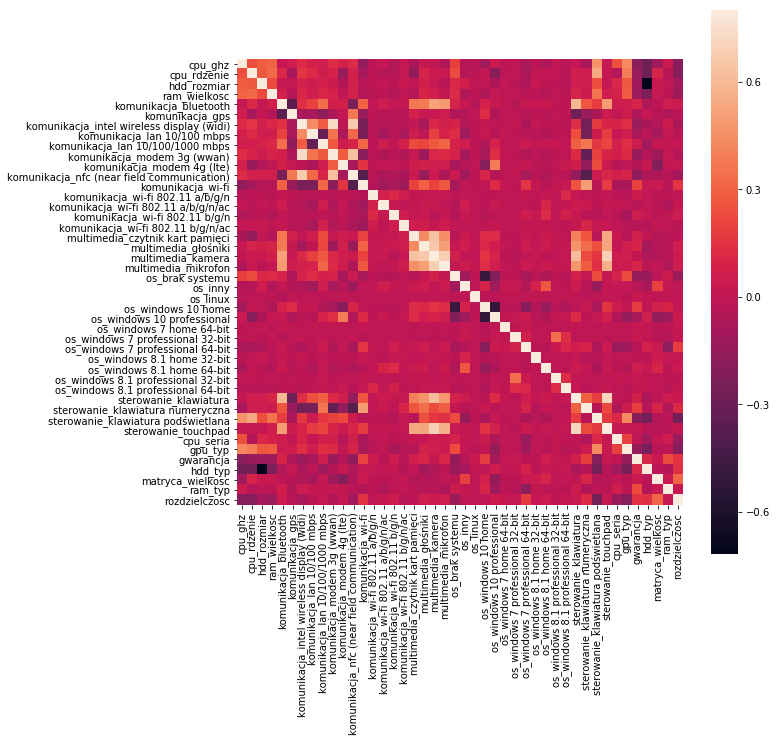

In [48]:
corrmat = dataset_X_en_pre.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Showing 20 most correlated pairs

In [49]:
get_top_abs_correlations(corrmat, num_of_features = 20)

hdd_rozmiar                                hdd_typ                                       0.955111
multimedia_kamera                          sterowanie_touchpad                           0.951850
komunikacja_intel wireless display (widi)  komunikacja_modem 3g (wwan)                   0.937113
multimedia_kamera                          multimedia_mikrofon                           0.932504
komunikacja_bluetooth                      sterowanie_klawiatura                         0.906666
sterowanie_klawiatura                      sterowanie_touchpad                           0.906312
multimedia_czytnik kart pamięci            multimedia_kamera                             0.893606
multimedia_głośniki                        multimedia_kamera                             0.890893
multimedia_mikrofon                        sterowanie_touchpad                           0.890096
multimedia_kamera                          sterowanie_klawiatura                         0.877114
multimedia_czytnik k

## 8. Training and validation split<a name='traintest'></a>

Since we would prefer not to overfit our model, we are going to split our training set into training and validation set. We are going to use standard 80/20 ratio, since then our training set will still be bigger than test set and validation set is going to have about 40% of number of records from test set, so the proportions of records are within reasonable range.

In [50]:
X_train_pre, X_val_pre, Y_train_pre, Y_val_pre = train_test_split(dataset_X_en_pre, dataset_Y, 
                                                          test_size=0.2, random_state=seed)

## 9. RMSE<a name='rmse'></a>

Here we define our metric which is going to be used as a benchmark for this data

In [51]:
def rmse(y_true, y_pred):
    mse = np.mean((y_pred - y_true)** 2)
    return np.sqrt(mse)

rmse_score = make_scorer(rmse, greater_is_better=False)

## 10. Modelling<a name='modelling'></a>

## 10.1 Linear regression<a name='lr'></a>

Firstly we are going to perform the simplest form of linear regression as our benchmark. We added variance inflation factor to avoid multicollinear features.

In [52]:
vif = VIFSelector(thresh=5.)
X_train_lr = vif.fit_transform(X_train_pre)

lr = LinearRegression()
lr.fit(X_train_lr, Y_train_pre)
pred = lr.predict(X_val_pre.loc[:, X_train_lr.columns])
rmse(pred, Y_val_pre)

1045.2748262526748

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

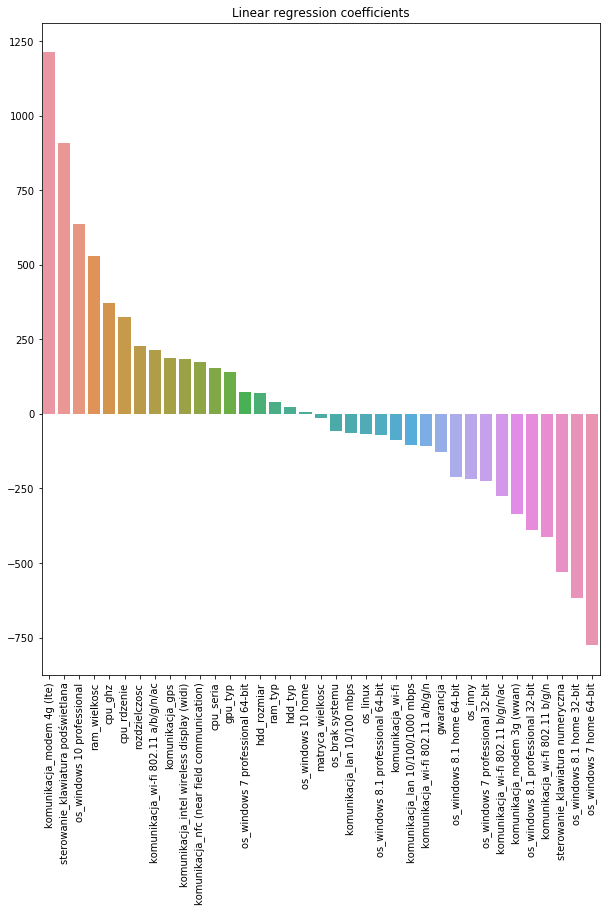

In [138]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,12))
#Assigning names to coefficients and sorting
coef_names = list(zip(lr.coef_, X_train_lr.columns))
coef_names.sort(reverse=True);
#Transposing a list of lists
coef_names = list(map(list, zip(*coef_names)))
sns.barplot(x = coef_names[1], y=coef_names[0])
plt.title("Linear regression coefficients")
plt.xticks(rotation=90)

## 10.2 Xgboost <a name='xgboost'></a>

XGBoost is an algorithm that won many data science competition and is not one of the most commonly used machine learning algorithms. The detailed description of working principles of XGBoost can be found here:

https://arxiv.org/pdf/1603.02754.pdf

In this task it seems reasonable to try with this algorithm due to the fact, that on the laptop market one can find different price segments (which is also visible on the price distribution, however medium ones are surely the most popular). Such segments can be found with xgboost usage, so we are going to use this approach. Moreover we are not going to perform variable selection, as in regression analysis, due to the fact that XGBoost can deal with collinearity on its own.

At first we are going to try XGBoost without any hyperparameter tuning.

In [139]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train_pre, Y_train_pre)
pred = xgbr.predict(X_val_pre)
rmse(pred, Y_val_pre)

636.406872950751

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

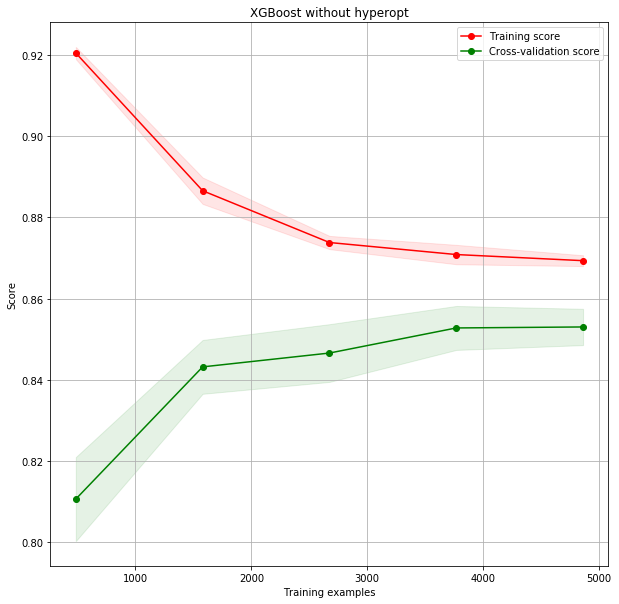

In [56]:
plot_learning_curve(X=X_train_pre, y = Y_train_pre, estimator=xgbr, cv=5, title="XGBoost without hyperopt")

With hyperparameter tuning

In [57]:
EXPERIMENT_NAME = 'xgboost_dev'

In [58]:
space = {
        'max_depth': hp.choice("max_depth", range(1, 13, 1)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'gamma' : hp.uniform ('gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('reg_alpha',0,1)
        }

In [59]:
reg_optim = RegressorOptimizer(
    regressor=xgbr,
    space=space,
    metric=rmse
)

We will to make sure that our model is not overfitting by adding penalty value in cases where prediction on validation set has more than 30% higher rmse than in case of training set. The addition of such penalty was justified by the fact that on previous training of this model we observed that it has great tendency to overfit. Presented run is not the first one, we performed experiments before, with about 1000 evaluations in total.

In [60]:
reg_optim.find_best_params(
    X_train_pre.values,
    Y_train_pre.values,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=2000,
    overfit_penalty=0.3
)

Train: 346.8667, valid: 513.6373                      
Train: 618.2895, valid: 653.1908                                              
Train: 481.8338, valid: 566.6060                                              
Train: 265.5742, valid: 489.7407                                              
Train: 406.7965, valid: 533.5261                                              
Train: 299.9019, valid: 507.4745                                              
Train: 613.5247, valid: 648.8408                                              
Train: 439.1006, valid: 548.5672                                              
Train: 318.9387, valid: 511.3910                                              
Train: 614.2139, valid: 654.9538                                              
Train: 924.7708, valid: 928.7386                                               
Train: 389.7064, valid: 530.3018                                               
Train: 378.0941, valid: 525.1024                                          

In [61]:
trials = pickle.load(open(os.path.join('../experiments/', '.'.join([EXPERIMENT_NAME, 'hpopt'])), 'rb'))

Extracting hyperparameters from the best trial

In [62]:
params = reg_optim.space_eval(trials.best_trial)
xgbr_hp = xgb.XGBRegressor(**params)
xgbr_hp.fit(X_train_pre, Y_train_pre)
pred = xgbr_hp.predict(X_val_pre)
rmse(pred, Y_val_pre)

503.64617328923447

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

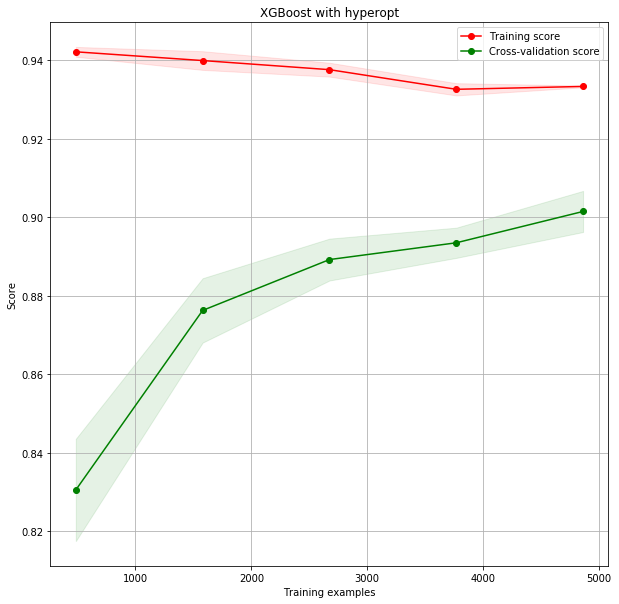

In [63]:
plot_learning_curve(X=X_train_pre, y = Y_train_pre, estimator=xgbr_hp, cv=5, title="XGBoost with hyperopt")

So one can see that our rmse score was about 20% lower after hyperparameter optimisation with Bayesian approach and additional penalty to the model.

## 10.3 Explaining prediction of XGBoost<a name='expxgboost'></a>

As written in documentation:
<br>
"SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. 
SHAP connects game theory with local explanations, 
uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations 
(see the SHAP NIPS paper for details)."

In case of our XGBRegressor, feature importance was based on "gain", which can be understood as the average training loss reduction gained when using a feature for splitting. There two other ways to explain xgboost features ("cover" and "weight"), but results from them are usually inconsistent

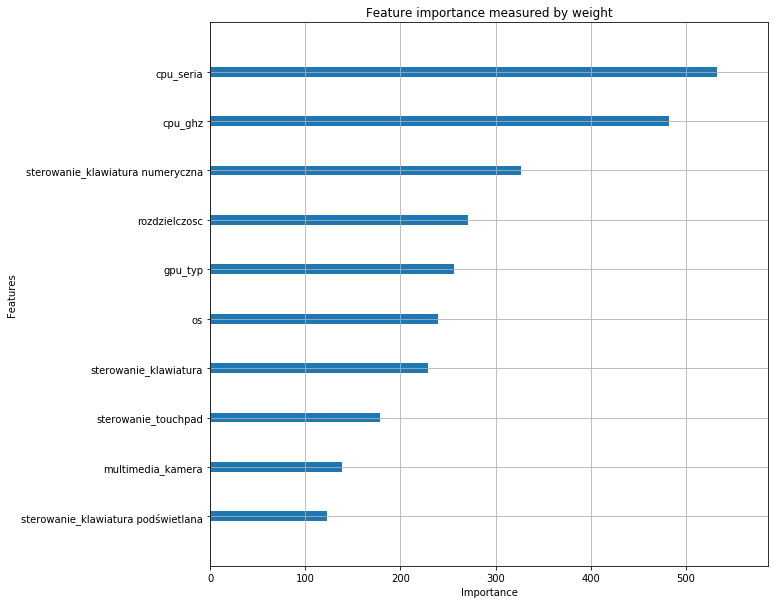

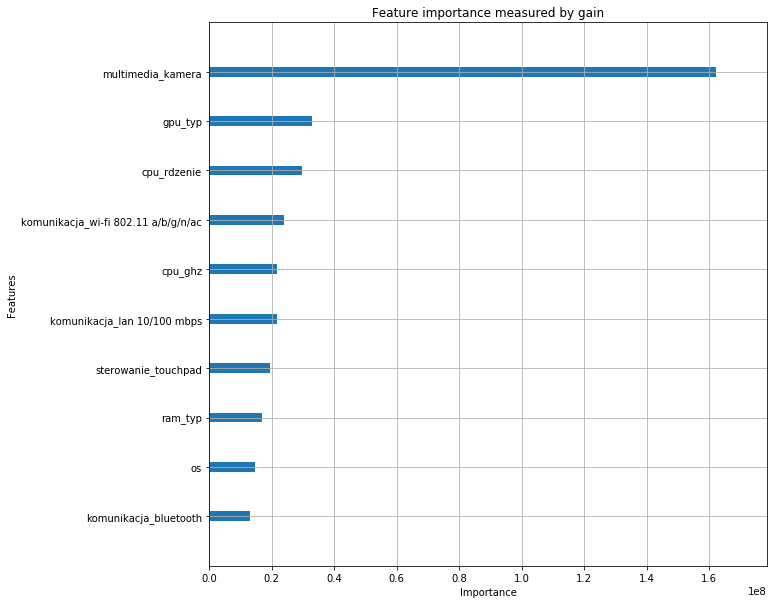

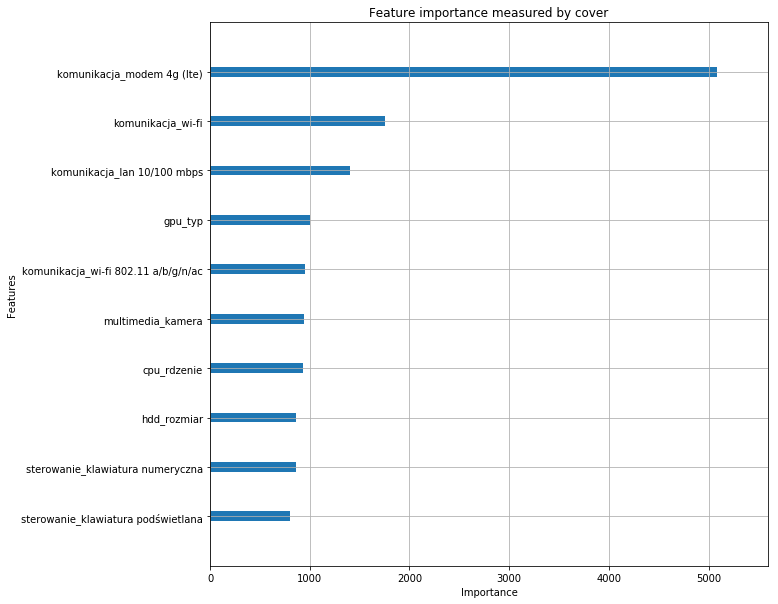

In [61]:
importance_type = ['weight', 'gain', 'cover']
for importance in importance_type:
    xgb.plot_importance(
                        xgbr_hp,
                        max_num_features=10, 
                        importance_type=importance, 
                        show_values=False, 
                        xlabel="Importance",
                        title=f"Feature importance measured by {importance}"
    )

One can see that there is no consistent result in this particular case (although cpu_seria and hdd_rozmiar are the most common ones, which is not surprising)

In [62]:
shap_values = shap.TreeExplainer(xgbr_hp).shap_values(X_val_pre)
shap_interaction_values = shap.TreeExplainer(xgbr_hp).shap_interaction_values(X_val_pre)

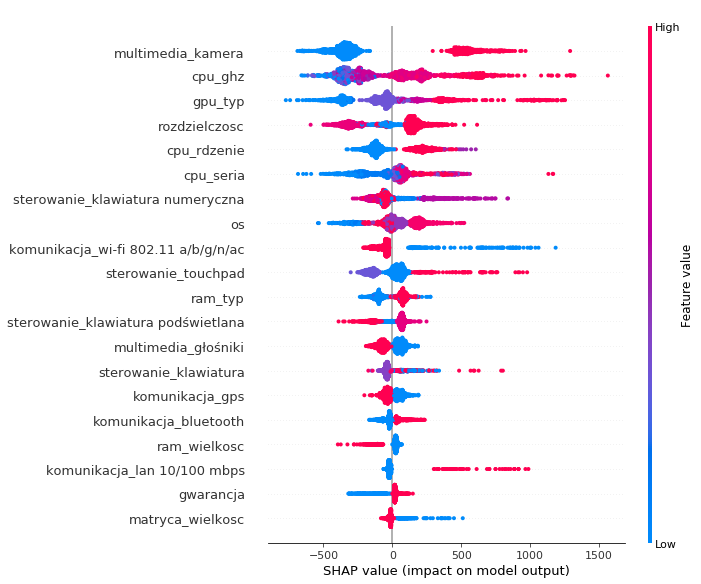

In [63]:
shap.summary_plot(shap_values, X_val_pre)

## 10.4 CatBoost<a name='catboost'></a>

In case of CatBoost we will firstly try not to use any type of encoding, since this algorithm can deal with such variables on the fly. Further explanation of the how does it deal with linear variables can be found in original paper:

http://learningsys.org/nips17/assets/papers/paper_11.pdf

We just need to convert int type values to float ones.

In [64]:
# TODO - Do not use one hot encoded variables - from catboost docs
dataset_X_cat = dataset_X_one_hot
integer_columns = dataset_X_cat.select_dtypes('int').columns
dataset_X_cat.loc[:, integer_columns] = \
dataset_X_cat.astype({integer: float for integer in dataset_X_cat.loc[:, integer_columns]})
X_train_cat, X_val_cat, Y_train_cat, Y_val_cat = train_test_split(dataset_X_cat, dataset_Y,
                                                                  test_size=0.2, random_state=seed)

In [65]:
names_trans_indices = [X_train_cat.columns.get_loc(column) for column in names_trans]

In [66]:
ctb=CatBoostRegressor(
                    iterations=1000, 
                    depth=3, 
                    learning_rate=0.1, 
                    loss_function='RMSE', 
                    verbose=0,
                    one_hot_max_size=2,
                    task_type="GPU"
)
ctb.fit(X_train_cat.values, Y_train_cat.values,cat_features=names_trans_indices, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [67]:
pred = ctb.predict(X_val_cat)
rmse(pred, Y_val_cat)

583.9544728761398

In [68]:
EXPERIMENT_NAME_CAT = 'catboost_first'

In [69]:
space_cat = {
        'bagging_temperature': hp.choice("bagging_temperature", range(0, 10, 1)),
        'depth': hp.choice ('depth', range(0, 10, 1)),
        'learning_rate': hp.uniform ('subsample', 0.01, 0.2),
        'iterations': hp.choice("iteration", range(100, 2000, 20)),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.001, 0.2),
        'border_count' hp.choice('border_count', (128, 254))
        }

In [70]:
reg_optim_cat = RegressorOptimizer(
    regressor=ctb,
    space=space_cat,
    metric=rmse
)

In [71]:
reg_optim_cat.find_best_params(
    X_train_cat.values,
    Y_train_cat.values,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME_CAT,
    max_evals=2000,
    overfit_penalty=0.3,
    cat_features=names_trans_indices
)

Train: 1699.0747, valid: 1699.1711                    
Train: 546.2102, valid: 609.6910                                                
  0%|          | 2/2000 [00:27<5:29:39,  9.90s/it, best loss: 568.8825157797456]


In [72]:
trials_cat = pickle.load(open(os.path.join('../experiments/', '.'.join([EXPERIMENT_NAME_CAT, 'hpopt'])), 'rb'))

In [73]:
params = reg_optim_cat.space_eval(trials_cat.best_trial)
ctb_hp = CatBoostRegressor(**params)
ctb_hp.fit(X_train_cat.values, Y_train_cat.values, cat_features=names_trans_indices)
pred = ctb_hp.predict(X_val_cat)
rmse(pred, Y_val_cat)

0:	learn: 3483.0530061	total: 14.9ms	remaining: 14.9s
1:	learn: 3142.1701913	total: 37.9ms	remaining: 18.9s
2:	learn: 2841.7048258	total: 63.9ms	remaining: 21.2s
3:	learn: 2580.4378296	total: 101ms	remaining: 25.2s
4:	learn: 2350.0310570	total: 122ms	remaining: 24.2s
5:	learn: 2146.4686353	total: 138ms	remaining: 22.9s
6:	learn: 1964.0638623	total: 153ms	remaining: 21.7s
7:	learn: 1809.4308790	total: 168ms	remaining: 20.9s
8:	learn: 1673.0454127	total: 185ms	remaining: 20.3s
9:	learn: 1552.3795652	total: 200ms	remaining: 19.8s
10:	learn: 1450.9890801	total: 218ms	remaining: 19.6s
11:	learn: 1363.1320005	total: 239ms	remaining: 19.7s
12:	learn: 1287.2344458	total: 267ms	remaining: 20.3s
13:	learn: 1216.1651449	total: 292ms	remaining: 20.6s
14:	learn: 1159.8666314	total: 309ms	remaining: 20.3s
15:	learn: 1109.7159115	total: 326ms	remaining: 20.1s
16:	learn: 1069.4266503	total: 342ms	remaining: 19.8s
17:	learn: 1031.1538902	total: 358ms	remaining: 19.5s
18:	learn: 990.2110470	total: 375ms

160:	learn: 597.3909397	total: 3.4s	remaining: 17.7s
161:	learn: 596.5452579	total: 3.43s	remaining: 17.7s
162:	learn: 594.6971068	total: 3.44s	remaining: 17.7s
163:	learn: 594.1799987	total: 3.46s	remaining: 17.6s
164:	learn: 594.1601014	total: 3.48s	remaining: 17.6s
165:	learn: 592.5887451	total: 3.49s	remaining: 17.5s
166:	learn: 591.1159918	total: 3.51s	remaining: 17.5s
167:	learn: 590.5307077	total: 3.53s	remaining: 17.5s
168:	learn: 590.4145608	total: 3.54s	remaining: 17.4s
169:	learn: 590.2721223	total: 3.56s	remaining: 17.4s
170:	learn: 590.1002210	total: 3.57s	remaining: 17.3s
171:	learn: 589.4571972	total: 3.59s	remaining: 17.3s
172:	learn: 589.4285693	total: 3.6s	remaining: 17.2s
173:	learn: 589.3881930	total: 3.63s	remaining: 17.2s
174:	learn: 589.0076661	total: 3.65s	remaining: 17.2s
175:	learn: 588.8861744	total: 3.68s	remaining: 17.2s
176:	learn: 588.8178258	total: 3.7s	remaining: 17.2s
177:	learn: 588.7435779	total: 3.71s	remaining: 17.2s
178:	learn: 588.0559273	total: 

313:	learn: 543.0736632	total: 6.08s	remaining: 13.3s
314:	learn: 542.8870747	total: 6.11s	remaining: 13.3s
315:	learn: 542.8464996	total: 6.13s	remaining: 13.3s
316:	learn: 542.7701213	total: 6.15s	remaining: 13.2s
317:	learn: 542.7117080	total: 6.16s	remaining: 13.2s
318:	learn: 542.5838129	total: 6.18s	remaining: 13.2s
319:	learn: 542.4085249	total: 6.21s	remaining: 13.2s
320:	learn: 541.9494436	total: 6.23s	remaining: 13.2s
321:	learn: 541.2274988	total: 6.26s	remaining: 13.2s
322:	learn: 541.1216437	total: 6.28s	remaining: 13.2s
323:	learn: 540.9259069	total: 6.32s	remaining: 13.2s
324:	learn: 539.6815353	total: 6.34s	remaining: 13.2s
325:	learn: 539.5435775	total: 6.37s	remaining: 13.2s
326:	learn: 539.4529511	total: 6.38s	remaining: 13.1s
327:	learn: 539.4292063	total: 6.4s	remaining: 13.1s
328:	learn: 539.4145580	total: 6.42s	remaining: 13.1s
329:	learn: 539.0408856	total: 6.44s	remaining: 13.1s
330:	learn: 538.8851218	total: 6.45s	remaining: 13s
331:	learn: 538.7393859	total: 

468:	learn: 511.8028813	total: 9.43s	remaining: 10.7s
469:	learn: 511.6724474	total: 9.44s	remaining: 10.6s
470:	learn: 511.5894185	total: 9.47s	remaining: 10.6s
471:	learn: 510.9657991	total: 9.48s	remaining: 10.6s
472:	learn: 510.8432066	total: 9.5s	remaining: 10.6s
473:	learn: 510.7300630	total: 9.52s	remaining: 10.6s
474:	learn: 510.5402305	total: 9.53s	remaining: 10.5s
475:	learn: 510.4304801	total: 9.55s	remaining: 10.5s
476:	learn: 510.3843158	total: 9.56s	remaining: 10.5s
477:	learn: 510.3413829	total: 9.58s	remaining: 10.5s
478:	learn: 510.3258906	total: 9.6s	remaining: 10.4s
479:	learn: 510.1928642	total: 9.61s	remaining: 10.4s
480:	learn: 510.0347872	total: 9.63s	remaining: 10.4s
481:	learn: 509.8011335	total: 9.65s	remaining: 10.4s
482:	learn: 509.6492200	total: 9.68s	remaining: 10.4s
483:	learn: 509.6083431	total: 9.7s	remaining: 10.3s
484:	learn: 509.5823931	total: 9.73s	remaining: 10.3s
485:	learn: 509.1964475	total: 9.75s	remaining: 10.3s
486:	learn: 509.1817725	total: 

625:	learn: 494.0912833	total: 12.1s	remaining: 7.25s
626:	learn: 493.6557744	total: 12.2s	remaining: 7.23s
627:	learn: 493.6221163	total: 12.2s	remaining: 7.21s
628:	learn: 493.5724519	total: 12.2s	remaining: 7.19s
629:	learn: 493.4946299	total: 12.2s	remaining: 7.16s
630:	learn: 493.4535904	total: 12.2s	remaining: 7.14s
631:	learn: 493.3752872	total: 12.2s	remaining: 7.13s
632:	learn: 493.3500880	total: 12.3s	remaining: 7.12s
633:	learn: 493.1780929	total: 12.3s	remaining: 7.1s
634:	learn: 493.1285175	total: 12.3s	remaining: 7.09s
635:	learn: 493.0071837	total: 12.4s	remaining: 7.08s
636:	learn: 492.8869437	total: 12.4s	remaining: 7.07s
637:	learn: 492.5772148	total: 12.4s	remaining: 7.06s
638:	learn: 492.5697125	total: 12.5s	remaining: 7.05s
639:	learn: 492.5207196	total: 12.5s	remaining: 7.03s
640:	learn: 492.4456610	total: 12.5s	remaining: 7.01s
641:	learn: 492.3476619	total: 12.5s	remaining: 7s
642:	learn: 492.3134909	total: 12.6s	remaining: 6.98s
643:	learn: 492.1524456	total: 1

780:	learn: 480.2133733	total: 15s	remaining: 4.21s
781:	learn: 480.0709347	total: 15s	remaining: 4.19s
782:	learn: 479.6188709	total: 15.1s	remaining: 4.17s
783:	learn: 479.4927445	total: 15.1s	remaining: 4.16s
784:	learn: 479.4512277	total: 15.1s	remaining: 4.13s
785:	learn: 478.8739610	total: 15.1s	remaining: 4.12s
786:	learn: 478.6915070	total: 15.1s	remaining: 4.1s
787:	learn: 478.5124721	total: 15.2s	remaining: 4.08s
788:	learn: 478.4921538	total: 15.2s	remaining: 4.06s
789:	learn: 478.4066556	total: 15.2s	remaining: 4.04s
790:	learn: 478.0497441	total: 15.2s	remaining: 4.03s
791:	learn: 478.0018466	total: 15.3s	remaining: 4.01s
792:	learn: 477.8458472	total: 15.3s	remaining: 3.99s
793:	learn: 477.7679389	total: 15.3s	remaining: 3.97s
794:	learn: 477.7644715	total: 15.3s	remaining: 3.95s
795:	learn: 477.3309518	total: 15.3s	remaining: 3.93s
796:	learn: 477.3296241	total: 15.4s	remaining: 3.91s
797:	learn: 477.2709296	total: 15.4s	remaining: 3.89s
798:	learn: 477.2639531	total: 15

940:	learn: 464.4553520	total: 17.7s	remaining: 1.11s
941:	learn: 464.4501942	total: 17.7s	remaining: 1.09s
942:	learn: 464.3071774	total: 17.8s	remaining: 1.07s
943:	learn: 464.1902089	total: 17.8s	remaining: 1.05s
944:	learn: 464.1601646	total: 17.8s	remaining: 1.04s
945:	learn: 464.0414972	total: 17.9s	remaining: 1.02s
946:	learn: 463.9243514	total: 17.9s	remaining: 1s
947:	learn: 463.8991982	total: 17.9s	remaining: 983ms
948:	learn: 463.8682985	total: 18s	remaining: 965ms
949:	learn: 463.7857609	total: 18s	remaining: 946ms
950:	learn: 463.5735990	total: 18s	remaining: 927ms
951:	learn: 463.5110822	total: 18s	remaining: 908ms
952:	learn: 463.5077016	total: 18s	remaining: 889ms
953:	learn: 463.4497992	total: 18s	remaining: 870ms
954:	learn: 463.4460899	total: 18.1s	remaining: 851ms
955:	learn: 463.4169502	total: 18.1s	remaining: 832ms
956:	learn: 463.4013214	total: 18.1s	remaining: 812ms
957:	learn: 463.3910805	total: 18.1s	remaining: 793ms
958:	learn: 463.3404991	total: 18.1s	remain

554.4273717138675

## 11. Summary<a name='summary'></a>